## Classical SDP relaxation of OPF
As a first step, we present a simple implementation of the classical SDP formulation of the Optimnal Power Flow problem using CVXPY.

### Setup
We start by importing pandapower for the test cases;
CVXPY, an open source Python-embedded modeling language for convex optimization problems;
MOSEK, a large scale optimization software. 

In [1]:
import pandapower.networks as nw
import pandapower as pp
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy.sparse import csr_matrix
import mosek
import plotly.express as px
import pandapower.plotting as plot

### Load Network Data
Now,let's make a function that loads the IEEE test cases from Pandapower.

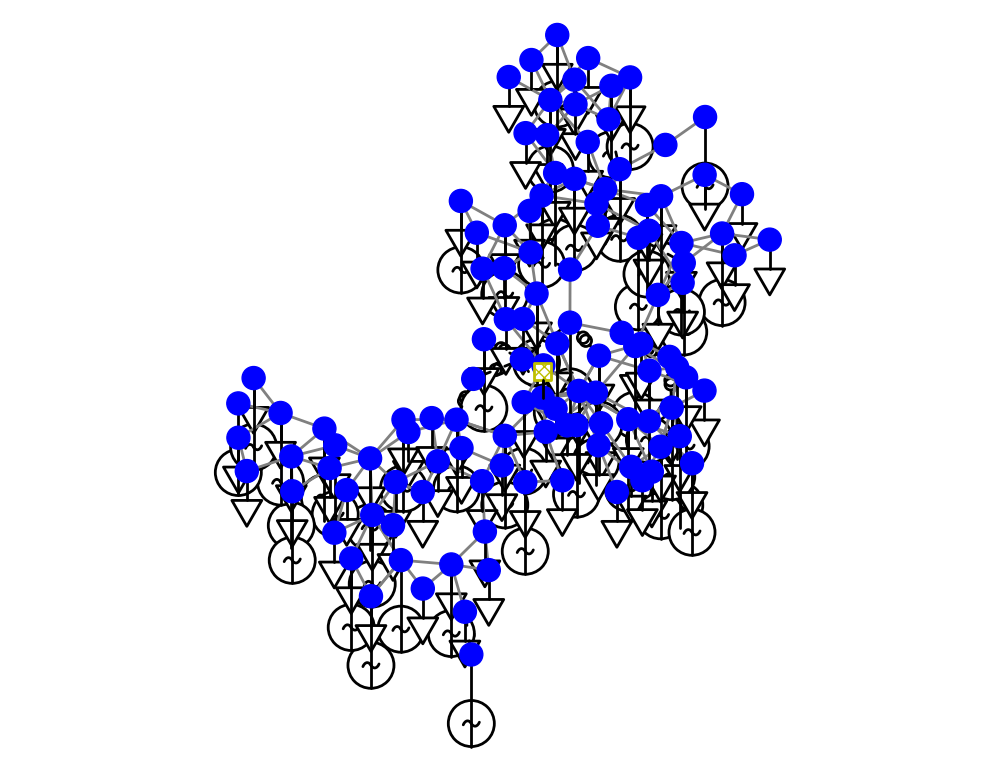

<Axes: >

In [58]:
# Select IEEE test case
def load_network(case):
    if case == 5:
        return nw.case5()
    if case == 14:
        return nw.case14()
    elif case == 30:
        return nw.case30()
    elif case == 57:
        return nw.case57()
    elif case == 118:
        return nw.case118()
    elif case == 300:
        return nw.case300()
    elif case == 'GB':
        return nw.GBnetwork()
    else:
        raise ValueError("Unsupported test case")
    
# Load the chosen IEEE test case
case_number = 118 # Change to 30, 57, or 118 for larger cases
net = load_network(case_number)
plot.simple_plot(net, show_plot=True, plot_loads=True, plot_gens=True, gen_size =4, load_size=3, line_width=2, bus_size=2)

When a power flow is carried out, the element based grid model is translated into a bus-branch model. That bus-branch model is stored in a data structure that is based on the PYPOWER/MATPOWER casefile (with some extensions). This ppc can be accessed after power flow using net._ppc
We will get the bus admittance matrix using exactly that and extract all the parameters we need.

## AC OPF Benchmark

In [60]:
# Run AC Optimal Power Flow
pp.runopp(net, verbose=True)
print("AC OPF")
print(net.res_bus)
print("Optimal Cost is", net.res_cost)

PYPOWER Version 5.1.4, 27-June-2018 -- AC Optimal Power Flow
Python Interior Point Solver - PIPS, Version 1.0, 07-Feb-2011
Converged!

Converged in 1.66 seconds
Objective Function Value = 129704.74 $/hr
| PyPower (ppci) System Summary - these are not valid for pandapower DataFrames|

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            118     Total Gen Capacity    9966.2       -7345.0 to 11777.0
Generators        54     On-line Capacity      9966.2       -7345.0 to 11777.0
Committed Gens    54     Generation (actual)   4320.4             738.1
Loads             99     Load                  4242.0            1438.0
  Fixed           99       Fixed               4242.0            1438.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts            14     Shunt (inj)             -0.0              90.9
Branches         186     Losses (I^2 * Z)  

## SDP OPF

In [62]:

##################   Set per-unit system   ######################
# Set base values for the per unit system
Vbase = net.bus.vn_kv[0] # Base voltage in kV, we will specify it for every line later
Sbase = net.sn_mva # Base apparent power in MVA
Zbase = Vbase**2 / Sbase  # in Ohms, we will specify it for every line later
Ybase = 1 / Zbase # base admittance in Siemens we will specify it for every line later
#################### extract Y bus and line info #########################

pp.runpp(net)   #we need to run power flow first to extract Y bus
Ybus = net._ppc["internal"]["Ybus"].todense()
n = len(net.bus)  # Number of buses

#we need line information to add line flow constraints
# Extract line connections as (from_bus, to_bus) tuples
lines = list(zip(net.line['from_bus'].astype(int), net.line['to_bus'].astype(int)))

#################### series admittance ##########################

y_lines = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    y_lines[(l,m)]= -Ybus[l, m]

###################### shunt admittance ######################

# Note c_nf_per_km (float) - line capacitance in nano Farad per km
y_shunt = {}
f = 50  # System frequency (Hz); change to 60 if using US grid
omega = 2 * np.pi * f  # Angular frequency (rad/s)

for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    Vbase = max(net.bus.loc[l, 'vn_kv'], net.bus.loc[m, 'vn_kv']) 
    Zbase = Vbase**2 / Sbase  # in Ohms
    Ybase = 1 / Zbase # base admittance in Siemens
    C_per_km = row['c_nf_per_km'] * 1e-9  # Capacitance in Farads/km
    length = row['length_km']      # Line length in km
    C_total = C_per_km * length  # Total capacitance in Farads
    B_total = omega * C_total      # Total susceptance in Siemens
    y_shunt_lm = 1j * B_total
    y_shunt_pu = y_shunt_lm/Ybase
    y_shunt[(l,m)]= y_shunt_pu
    

##################### Double check s_max (maximum apparent power) ####################################

# Define s_max for each line using max_i_ka and Vbase
s_max = {}
p_max = {}
max_v_diff_lm = {}
for idx, row in net.line.iterrows():
    l = int(row['from_bus'])
    m = int(row['to_bus'])
    Imax = row['max_i_ka']  # in kA  
    Vbase = max(net.bus.loc[l, 'vn_kv'], net.bus.loc[m, 'vn_kv']) 
    #s_max[(l, m)] = np.sqrt(3) * Vbase * Imax  #convert to MVA
    s_max[(l, m)] = np.sqrt(3) * Vbase * Imax * 1e3  # Convert to MW
    # Since we don't have info on P^max_lm, we will assume it is 95% of S^max_lm.
    p_max[(l, m)] = 0.95 * s_max[(l, m)]
    # Since we don't have the maximum voltage difference across a line, we will estimate it
    v_max_l = net.bus.loc[l, "max_vm_pu"]
    v_min_m = net.bus.loc[m, "min_vm_pu"]
    v_max_m = net.bus.loc[m, "max_vm_pu"]
    v_min_l = net.bus.loc[l, "min_vm_pu"]
    max_v_diff_lm[(l,m)] = max(abs(v_max_l - v_min_m), abs(v_max_m - v_min_l))

######################################################################

# Extract generator information for generation constraints
# Combine all generators, keep them separate
all_gen = pd.concat([
    net.gen.assign(type="gen"),
    net.sgen.assign(type="sgen"),
    net.ext_grid.assign(type="ext")
])
all_gen.reset_index(inplace=True)
gen_buses = all_gen["bus"].values
#all_gen = all_gen.groupby("bus").sum(numeric_only=True).reset_index() #if multiple generators are present at a bus, combine them.

# Extract load for generation constraints
load_buses = net.load["bus"].values #index of the load buses.
#load active and reactive power for load
p_load = np.zeros(n)
q_load = np.zeros(n)
all_load = net.load.groupby("bus").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.
for i,row in all_load.iterrows():
    p_load[int(row['bus'])] = row['p_mw'] 
    q_load[int(row['bus'])] = row['q_mvar']
    
# Extract min and max power for generation constraints
min_p = np.zeros(n)
max_p = np.zeros(n)
min_q = np.zeros(n)
max_q = np.zeros(n)

for i,row in all_gen.iterrows():
    min_p[int(row['bus'])] = row['min_p_mw'] 
    max_p[int(row['bus'])] = row['max_p_mw']
    min_q[int(row['bus'])] = row['min_q_mvar'] 
    max_q[int(row['bus'])] = row['max_q_mvar']  
    
# Voltage limits
min_v_pu = net.bus["min_vm_pu"].values ** 2  # Squared for SDP
max_v_pu = net.bus["max_vm_pu"].values ** 2

# Slack bus voltage
vm_slack = net.ext_grid['vm_pu'][0] #initial voltage of the slack

# Slack bus
slack_bus = int(net.ext_grid["bus"].iloc[0])

#######################################################################

# Extract generator cost coefficients from net.poly_cost
c2 = np.zeros(n)
c1 = np.zeros(n)
c0 = np.zeros(n)
#all_cost = net.poly_cost.groupby("element").sum(numeric_only=True).reset_index() #if multiple loads are present at a bus, combine them.

gen_bus = net.gen[net.gen['controllable'] == True].copy()
gen_bus = net.gen[["bus"]].reset_index()
gen_cost = net.poly_cost[net.poly_cost['et'] == 'gen'].copy()
gen_combined = pd.merge(
    gen_bus,       # reset index to merge by position
    gen_cost,
    left_on='index',             # gen index
    right_on='element',        # matches the 'element' column in poly_cost
    how='left'                   # in case some gens don't have cost
)
ext_grid_row = net.poly_cost[net.poly_cost["et"] == "ext_grid"].copy()
ext_grid_row["bus"] = 0
all_cost = pd.concat([ext_grid_row, gen_combined], ignore_index=True)

for i,row in all_cost.iterrows():
    c2[int(row['bus'])] = row['cp2_eur_per_mw2'] # Quadratic cost coefficients
    c1[int(row['bus'])] = row['cp1_eur_per_mw']  # Linear cost coefficients
    c0[int(row['bus'])] = row['cp0_eur']  # Constant cost coefficients

In [ ]:


############################## Initialize ###################################
# Define our problem matrix, W. It is 2n x 2n, where the first n rows and columns correspond to the real part of the voltage, and the second n rows and columns correspond to the imaginary part of the voltage.
W = cp.Variable((2*n, 2*n), PSD=True)

# Initialize the problem matrices
Y_set = {} # Hermitian part of Y_j
Y_bar_set = {} # Skewed Hermitian part of Y_j
M_set = {}

for k in range(n):
    e_k = np.zeros((n, 1))
    e_k[k] = 1
    Yk = e_k @ e_k.T @ Ybus #Yk is the admittance matrix with only the (k,k) entry, everything else is zero
    
    #Y_k is the Hermitian part of Y_k
    Y_k = 1/2 * np.block([
        [np.real(Yk + Yk.T),     np.imag(Yk.T - Yk)],
        [np.imag(Yk - Yk.T),     np.real(Yk + Yk.T)]
    ])
    #print('Size of Y_k', Y_k.shape)
    #Y_kbar is the skewed Hermitian part of Y_k
    Y_kbar = -1/2 * np.block([
        [np.imag(Yk + Yk.T),    np.real(Yk - Yk.T)],
        [np.real(Yk.T - Yk),    np.imag(Yk + Yk.T)]
    ])
    #print('Size of Y_kbar', Y_kbar.shape)
    #M_k is the matrix that will be used to enforce the voltage constraints
    M_k = np.block([
        [e_k @ e_k.T,       np.zeros((n, n))],
        [np.zeros((n, n)), e_k @ e_k.T]
    ])
    #print('Size of M_k', M_k.shape)
    Y_set[k] = Y_k
    Y_bar_set[k] = Y_kbar
    M_set[k] = M_k

# Create the matrices for the line constraints
M_line_set = {}
Y_line_set = {}
Y_bar_line_set = {}

for (l, m) in lines:  # lines is a list of (l, m) tuples

    e_l = np.zeros((n, 1))
    e_m = np.zeros((n, 1))
    e_l[l] = 1
    e_m[m] = 1
    delta = e_l - e_m
    M_lm = np.block([
        [delta @ delta.T,          np.zeros((n, n))],
        [np.zeros((n, n)), delta @ delta.T]
    ])
    M_line_set[(l, m)] = M_lm

    # y_lm and y_shunt_lm from precious
    y_lm = y_lines[(l, m)]         
    y_shunt_lm = y_shunt[(l, m)]

    Ylm = (y_shunt_lm + y_lm) * (e_l @ e_l.T) - y_lm * (e_l @ e_m.T)
    #print('Size of Y_lm', Ylm.shape)

    Y_lm = 1/2 * np.block([
        [np.real(Ylm + Ylm.T),      np.imag(Ylm.T - Ylm)],
        [np.imag(Ylm - Ylm.T),     np.real(Ylm + Ylm.T)]
    ])
    #print('Size of Y_lm', Y_lm.shape)
    Y_lmbar = -1/2 * np.block([
        [np.imag(Ylm + Ylm.T),      np.real(Ylm - Ylm.T)],
        [np.real(Ylm.T - Ylm),    np.imag(Ylm + Ylm.T)]
    ])
    #print('Size of Y_lmbar', Y_lmbar.shape)
    Y_line_set[(l, m)] = Y_lm
    Y_bar_line_set[(l,m)] = Y_lmbar

############################## Objective Function #############################

# gamma = 1e3
# norm_alpha = cp.sum(alpha) / 1000
# norm_traceW = cp.trace(W)

alpha = cp.Variable(n)
# objective = cp.Minimize(cp.sum(alpha))

gamma = 1e-3
# norm_alpha = cp.sum(alpha) / 1000
# norm_traceW = cp.trace(W) / 1
objective = cp.Minimize(cp.sum(alpha))

    
############################## Constraints ####################################
constraints = []
#P_G = cp.Variable(len(all_gen)) #Create a new active power variable for each generator (specifically for multiple generators at one bus)
#Q_G = cp.Variable(len(all_gen)) ##Create a new reactive power variable for each generator
Pin = {}
Qin = {}
S_alpha = {}
for k in range(n):

    ############################## Power Constraints ###################################
    
    Pin[k] = cp.trace(Y_set[k] @ W) * Sbase
    Qin[k] = cp.trace(Y_bar_set[k] @ W) * Sbase
    #print('Pin for bus', k, Pin[k])
    #print('Qin for bus', k, Qin[k])
    
    constraints.append(min_p[k] - p_load[k] <= Pin[k]) #constraint 4a
    constraints.append(Pin[k] <= max_p[k] - p_load[k]) #constraint 4a
    constraints.append(min_q[k] - q_load[k] <= Qin[k]) #constraint 4b
    constraints.append(Qin[k] <= max_q[k] - q_load[k]) #constraint 4b


    ############################# Cost Constraint #######################################
    
    a_k = c0[k] + c1[k] * p_load[k]
    b_k = float(np.sqrt(c2[k])) * p_load[k]

    top_left = c1[k] * Pin[k] - alpha[k] + a_k
    top_right = float(np.sqrt(c2[k])) * Pin[k] + b_k


    S_alpha[k] = cp.bmat([
        [top_left, top_right],
        [top_right, -1]
    ])
    constraints.append( S_alpha[k] << 0) # constraint 6

    # constraints.append(alpha[k] >= c1[k]*(Pin[k]+p_load[k]))
    # print(k)
    # print(p_load[k])
    # print(c1[k])
    
    ############################## Voltage Constraints #####################################
    # For the slack bus, we fix the voltage magnitude since it is not adjustable
    if k == slack_bus:
        constraints.append(cp.trace(M_set[k] @ W) == vm_slack**2)

    else:

        # Voltage constraints (except slack)
        constraints.append(min_v_pu[k] <= cp.trace(M_set[k] @ W)) #constraint 4c, note that min_v_pu is already squared and in pu
        constraints.append(cp.trace(M_set[k] @ W) <= max_v_pu[k]) #constraint 4c


######################## Line Flow Constraints ####################################

P_lm = {}
Q_lm = {}
S_line = {}
for (l, m) in lines:
    P_lm[(l, m)] = cp.trace(Y_line_set[(l, m)] @ W) * Sbase
    Q_lm[(l, m)] = cp.trace(Y_bar_line_set[(l, m)] @ W) * Sbase
    

    S_line[(l,m)] = cp.bmat([
        [-s_max[(l, m)]**2, P_lm[(l, m)], Q_lm[(l, m)]],
        [P_lm[(l, m)], -1, 0],
        [Q_lm[(l, m)], 0, -1]
    ])
    #constraints.append(P_lm <= p_max[(l,m)])  # constraint 4e
    #constraints.append(cp.trace(M_line_set[(l,m)]@W) <= max_v_diff_lm[l,m]**2)  # constraint 4f
    #if s_max[(l, m)] < 1e6:
        #constraints.append(S_line[(l,m)] << 0) # constraint 5

################# Positive semidefinite constraint   #####################################
# W_vec = cp.Variable((2*n, 1))
# constraints.append(W == W_vec @ W_vec.T)
constraints.append(W >> 0) ##constraint 4g

########################## Solve the SDP ##################################################
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)

########################## Print results  ####################################
print("Problem Status:", prob.status)
print("Optimal cost EUR:", prob.value)
print("AC OPF Solution:")
print(net.res_gen)
print(net.res_ext_grid)
print("SDP OPF Solution:")
for k in range(n):
    Pin_k = cp.trace(Y_set[k] @ W) * Sbase
    Qin_k = cp.trace(Y_bar_set[k] @ W) * Sbase
    print(f"Generator at bus {k}: P = {Pin_k.value + p_load[k]:.3f} MW, Q = {Qin_k.value+q_load[k]:.3f} MVAr")
W_value = W.value
W_value[np.abs(W_value)<= 1e-6] = 0
#Check the rank of W
eigvals = np.linalg.eigvalsh(W_value)
rank_W = np.linalg.matrix_rank(W_value, tol=1e-2)  # numerical rank threshold
print("Eigenvalues of W (SDP):", eigvals)
print("rank of W (SDP)", rank_W)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jul 29 02:14:37 PM: Your problem has 55814 variables, 56875 constraints, and 0 parameters.
(CVXPY) Jul 29 02:14:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 29 02:14:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 29 02:14:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 29 02:14:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 29 02:14:38 PM: Compiling problem (target solver=MOSE

In [42]:
all_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2,bus,index
0,0,ext_grid,0.0,2.00,0.02000,0.0,0.0,0.0,0,NaN
1,0,gen,0.0,1.75,0.01750,0.0,0.0,0.0,1,0.0
2,1,gen,0.0,1.00,0.06250,0.0,0.0,0.0,21,1.0
3,2,gen,0.0,3.25,0.00834,0.0,0.0,0.0,26,2.0
4,3,gen,0.0,3.00,0.02500,0.0,0.0,0.0,22,3.0
5,4,gen,0.0,3.00,0.02500,0.0,0.0,0.0,12,4.0


In [66]:
for (l, m) in lines:
    Slm_val = S_line[(l, m)].value
    if Slm_val is not None:
        eigvals = np.linalg.eigvalsh(Slm_val)
        print(f"Line ({l},{m}): eigenvalues of S_line = {eigvals}")
    else:
        print("eigenvalue is none")

eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none
eigenvalue is none


In [47]:
# Print constraints with large coefficients
for i, constraint in enumerate(prob.constraints):
    print(f"Constraint {i}: {constraint}")

Constraint 0: 0.0 <= trace([[6.30 -2.50 ... 0.00 0.00]
 [-2.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var1) @ 100.0
Constraint 1: trace([[6.30 -2.50 ... 0.00 0.00]
 [-2.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var1) @ 100.0 <= 80.0
Constraint 2: -20.0 <= trace([[19.90 -7.50 ... 0.00 0.00]
 [-7.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var1) @ 100.0
Constraint 3: trace([[19.90 -7.50 ... 0.00 0.00]
 [-7.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var1) @ 100.0 <= 150.0
Constraint 4: Promote(0.0, (2, 2)) + -Vstack(Hstack(reshape(2.0 @ trace([[6.30 -2.50 ... 0.00 0.00]
 [-2.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]] @ var1) @ 100.0 + -var2[0], (1,), F), reshape(0.1414213562373095 @ trace([[6.30 -2.50 ... 0.00 0.00]
 [-2.50 0.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0